<a href="https://colab.research.google.com/github/matheuslopes99/matheuslopes99/blob/main/Pytorch_Convolutional.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import matplotlib.pyplot as plt
import os

from torchvision.datasets import CIFAR10

In [3]:
DATA_DIR = '/content/drive/MyDrive/Colab Notebooks/content_cifa10'
CATEGORIES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [4]:
cifar10_train = CIFAR10(DATA_DIR, train=True, download=True)
cifar10_test = CIFAR10(DATA_DIR, train=False, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
def lookat_dataset(dataset, istensor=False):
  figure = plt.figure(figsize=(8, 8))
  rows, cols = 2, 2
  for i in range(1, 5):
    sample_idx = torch.randint(len(dataset), size=(1,)).item()
    img, label = dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(CATEGORIES[label])
    plt.axis("off")
    if istensor:
      plt.imshow(img.squeeze().permute(1,2,0))
    else:
      plt.imshow(img)
  plt.show()

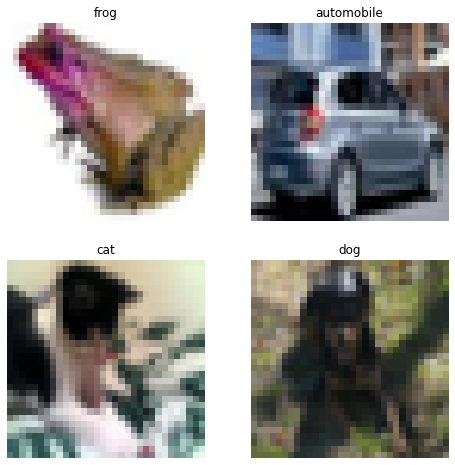

In [6]:
lookat_dataset(cifar10_train)

**Pré-processamento dos dados**

In [7]:
import torchvision.transforms as T

In [8]:
prep_transform = T.Compose([T.ToTensor(),
                            T.Normalize((0.4914, 0.4822, 0.4465),
                                       (0.2470, 0.2435, 0.2616))])
tensor_train = CIFAR10(DATA_DIR, train=True, download=False, transform = prep_transform)
tensor_test = CIFAR10(DATA_DIR, train=False, download=False, transform = prep_transform)

In [9]:
imgs = torch.stack([img_t for img_t, _ in tensor_train], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [10]:
imgs.view(3, -1).mean(dim=1)

tensor([-1.2762e-06, -1.7074e-04,  1.1819e-04])

In [11]:
imgs.view(3, -1).std(dim=1)

tensor([1.0001, 0.9999, 1.0000])

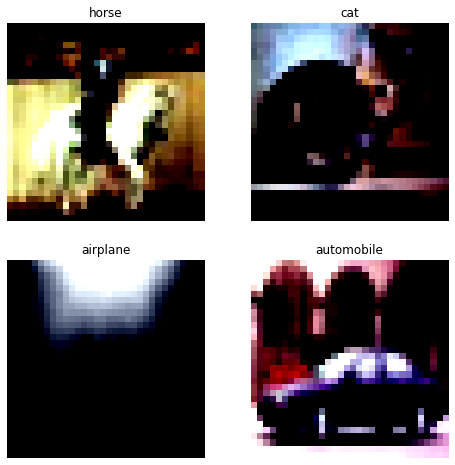

In [12]:
lookat_dataset(tensor_train, True)

**Criando dataloaders**

In [13]:
from torch.utils.data import DataLoader

In [14]:
batch_size = 64
train_loader = DataLoader(tensor_train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(tensor_train, batch_size=batch_size, shuffle=True)

**Construindo uma rede MLP**

In [15]:
from torch import nn

In [16]:
class MLPClassifier(nn.Module):
  def __init__(self):
    super().__init__()  
    self.flatten = nn.Flatten()
    self.layers = nn.Sequential(
        nn.Linear(32*32*3, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128,64),
        nn.ReLU(),
        nn.Linear(64,10)       
    )
  def forward(self, x):
    v = self.flatten(x)
    return self.layers(v)

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Rodando na", device)

Rodando na cuda


In [19]:
model = MLPClassifier().to(device)

**Escolhendo hiperparâmetros de otimização**

In [20]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
lossfunc = nn.CrossEntropyLoss()

In [22]:
def train(model, dataloader, lossfunc, optimizer):
  model.train()
  cumulativeloss = 0.0
  for imgs, labels in dataloader:
    imgs, labels = imgs.to(device), labels.to(device)

    pred = model(imgs)

    loss = lossfunc(pred, labels)

    #zera os gradientes acumulados
    optimizer.zero_grad()
    #computa os gradientes
    loss.backward()
    #anda, na direção que reduz o erro local
    optimizer.step()
    #loss é um tensor; item pra obter float
    cumulativeloss+= loss.item()

  return cumulativeloss / len(dataloader)

def validate(model, dataloader, lossfunc):
  model.eval()
  cumulativeloss = 0.0
  with torch.no_grad():
    for imgs, labels in dataloader:
      imgs, labels = imgs.to(device), labels.to(device)

      pred = model(imgs)
      loss = lossfunc(pred, labels)

      cumulativeloss+= loss.item()

  return cumulativeloss / len(dataloader)

In [24]:
epochs = 31
train_losses = []
test_losses = []
for t in range(epochs):
  train_loss = train(model, train_loader, lossfunc, optimizer)
  train_losses.append(train_loss)
  if t%10 == 0:
    print("Train loss:", train_loss)
  test_loss = validate(model, test_loader, lossfunc)
  test_losses.append(test_loss)

Train loss: 2.2627752616887205
Train loss: 1.8084801658035239
Train loss: 1.624550805829675
Train loss: 1.5047863305682112
